# Regression - Assignment 3

## Data and Package Import

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pylab as plt

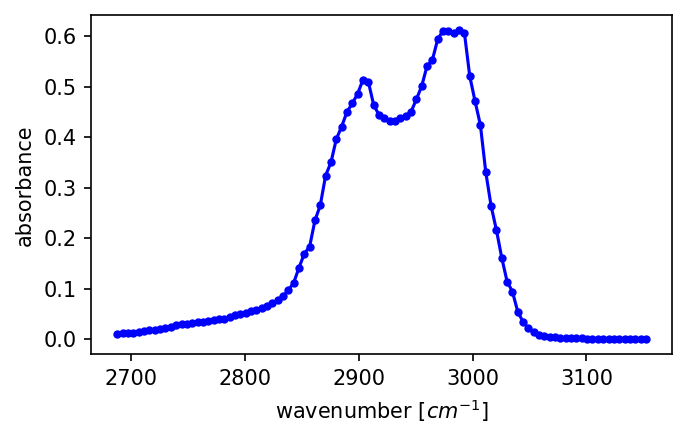

In [2]:
df = pd.read_csv('data/ethanol_IR.csv')
x_all = df['wavenumber [cm^-1]'].values
y_all = df['absorbance'].values

x_peak = x_all[475:575]
y_peak = y_all[475:575]

fig, ax = plt.subplots(figsize = (5, 3), dpi = 150)
ax.plot(x_peak, y_peak, '-b', marker = '.')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

## 1. Linear Interpolation

**Select every third datapoint from `x_peak` and `y_peak` dataset.**

In [3]:
x_third = x_peak[::3]
y_third = y_peak[::3]

**Use these datapoints to train a linear interpolation model.**

Predict the full dataset using the model and plot the result along with the original dataset.

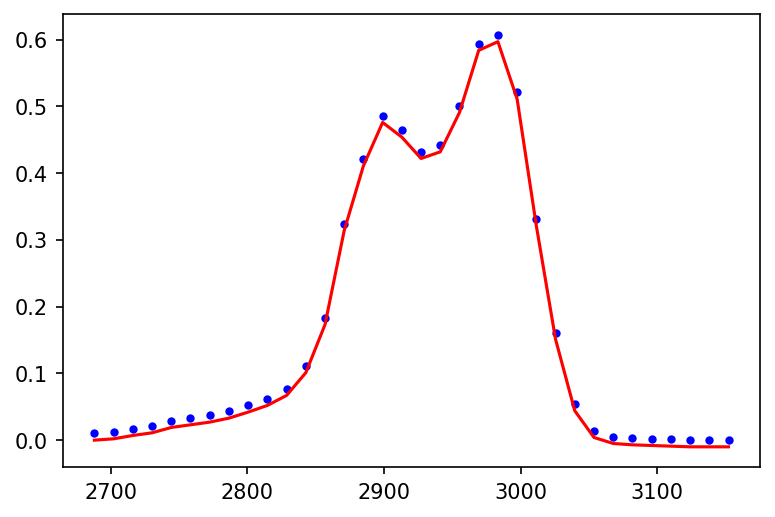

In [4]:
from sklearn.linear_model import LinearRegression

def piecewise_linear(x_train, x_test = None):
    if x_test is None:
        x_test = x_train
        
    N = len(x_test)
    M = len(x_train)
    X = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            X[i, j] = max(0, x_test[i] - x_train[j])
    return X

X_third = piecewise_linear(x_third)
X_third[:, -1] += 1

model = LinearRegression(fit_intercept = False)
model.fit(X_third, y_third)

X_third_test = piecewise_linear(x_third, x_peak)
yhat = model.predict(X_third_test)

fig, ax = plt.subplots(dpi = 150)
ax.plot(x_third, y_third, '.b')
ax.plot(x_peak, yhat, '-r')
plt.show()

**Evaluate the performance of `rbf` kernel as a function of kernel width.**

Use the same strategy as the previous exercise. Vary the width of the radial basis function with $\sigma$ = [1, 10, 50, 100, 150].

Compute the $r^2$ score for each using the entire dataset.

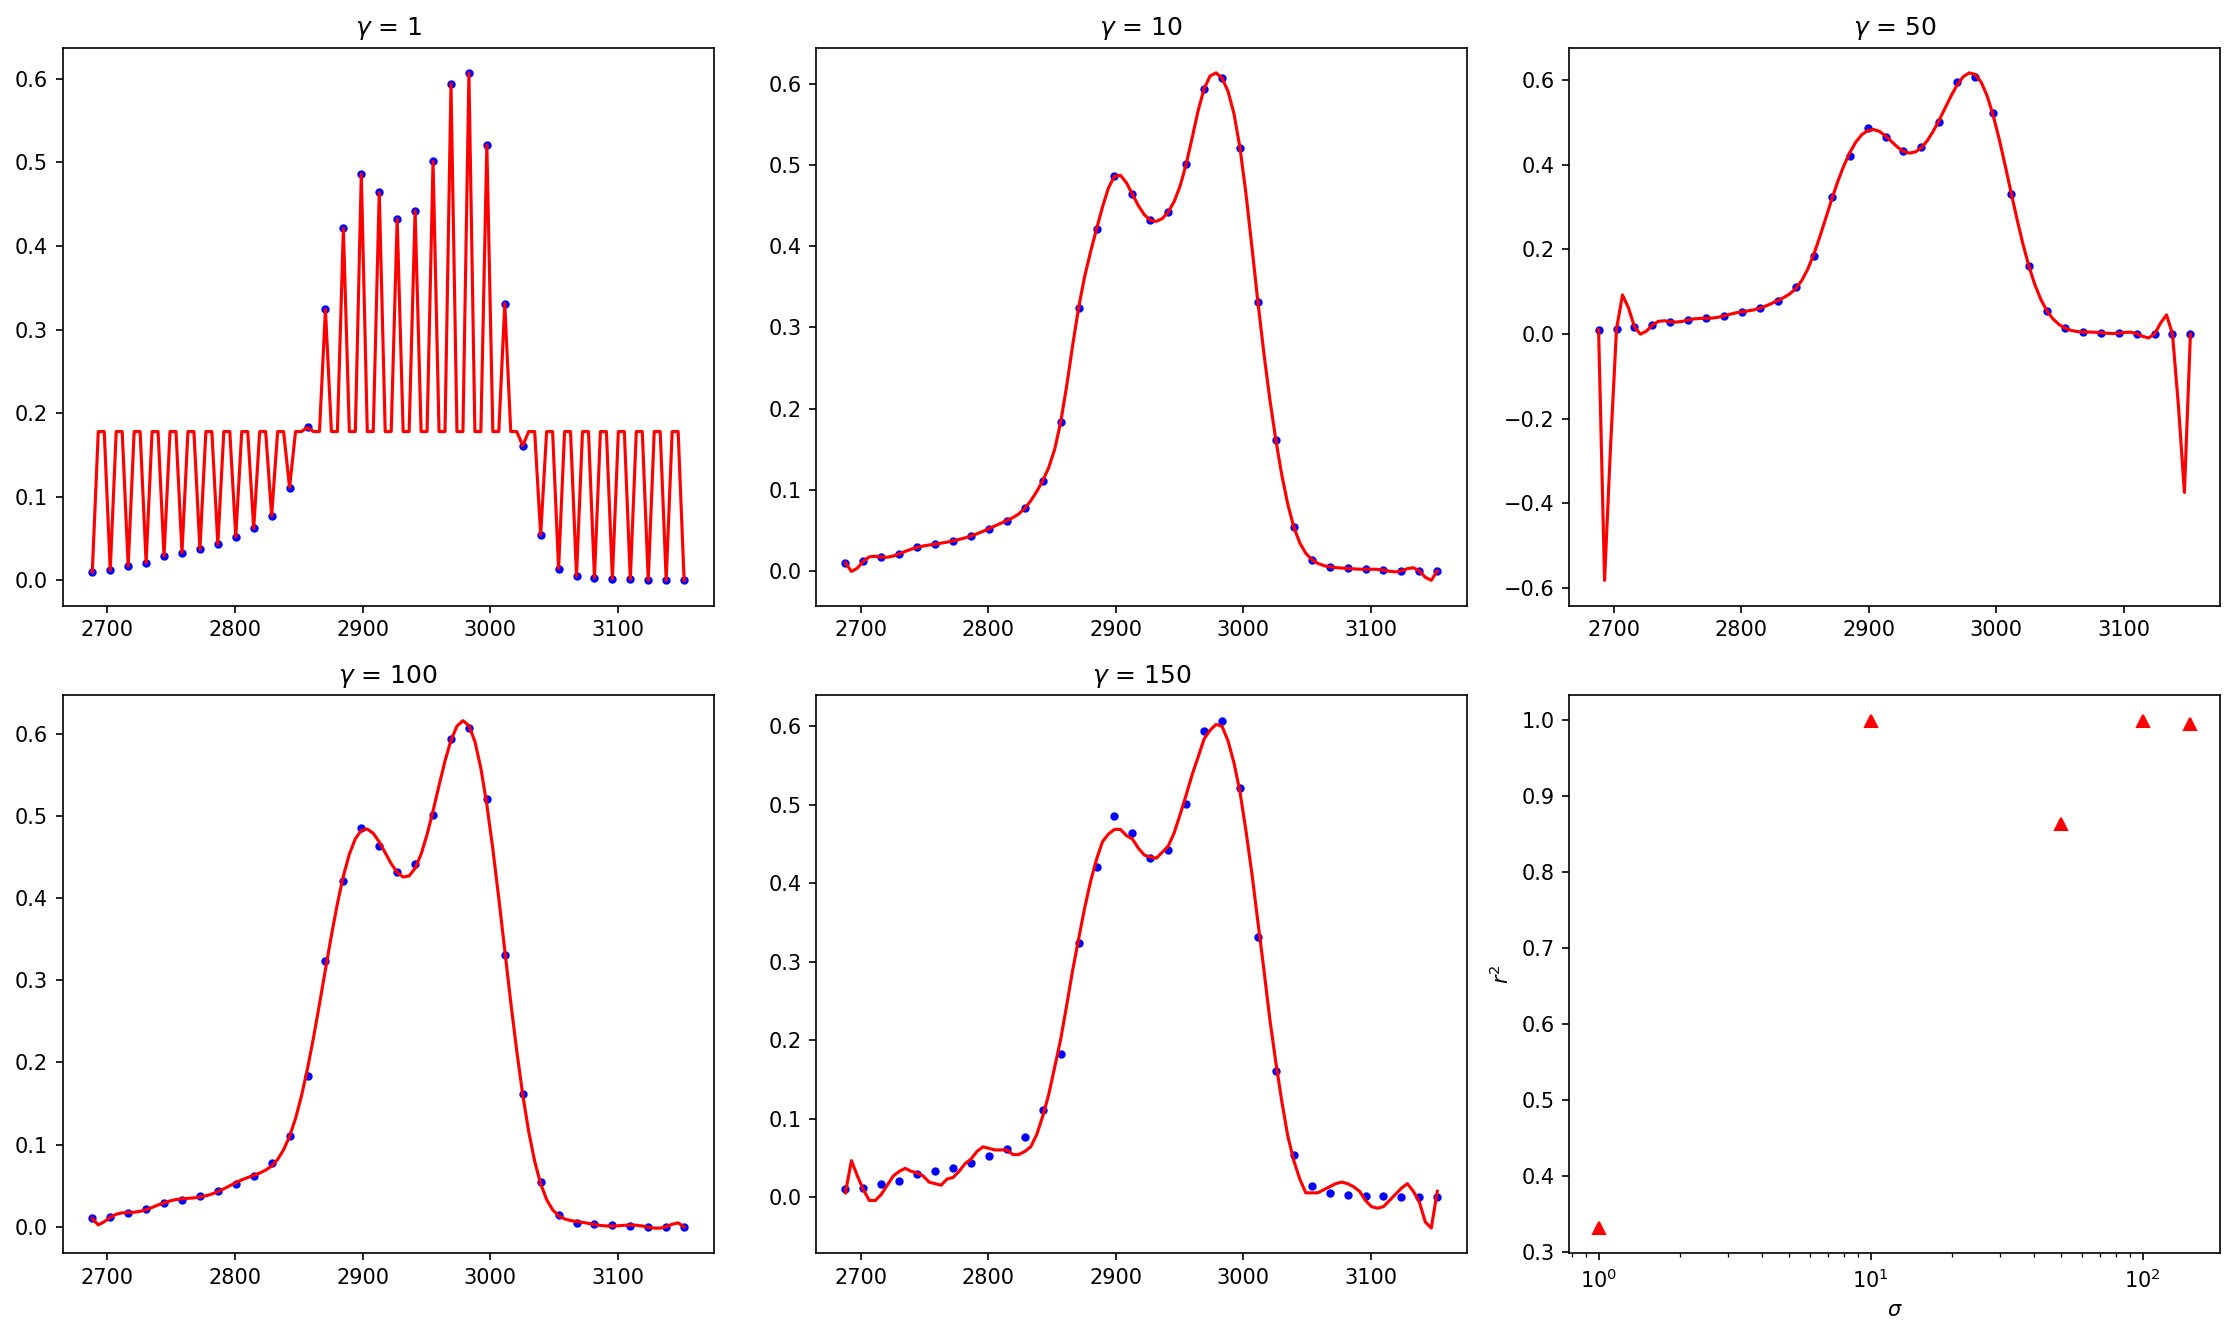

In [5]:
sigmas = np.array([1, 10, 50, 100, 150])
gammas = 1. / 2 / sigmas**2

def rbf(x_train, x_test = None, gamma = 1):
    if x_test is None:
        x_test = x_train
        
    N = len(x_test)
    M = len(x_train)
    X = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            X[i, j] = np.exp(-gamma * (x_test[i] - x_train[j])**2)
            
    return X

x_third = x_peak[::3]
y_third = y_peak[::3]

r2 = []

fig, axes = plt.subplots(2, 3, figsize = (15, 9), dpi = 150)
axes = axes.ravel()

for i, gamma in enumerate(gammas):
    rbf_third = rbf(x_third, gamma = gamma)
    
    model = LinearRegression()
    model.fit(rbf_third, y_third)
    
    rbf_test = rbf(x_third, x_peak, gamma = gamma)
    yhat = model.predict(rbf_test)
    
    axes[i].plot(x_third, y_third, '.b')
    axes[i].plot(x_peak, yhat, '-r')
    axes[i].set_title('$\gamma$ = {}'.format(sigmas[i]))
    
    r2.append(model.score(rbf_test, y_peak))
    
axes[-1].plot(sigmas, r2, 'r^')
axes[-1].set_xscale('log')
axes[-1].set_xlabel('$\sigma$')
axes[-1].set_ylabel('$r^2$')

plt.tight_layout()

**Create a model where $r^2$ < 0.**

You can use any model from the lectures, or make one up.

The model you use does not have to optimized using the data.

r^2: -0.7176717166021713


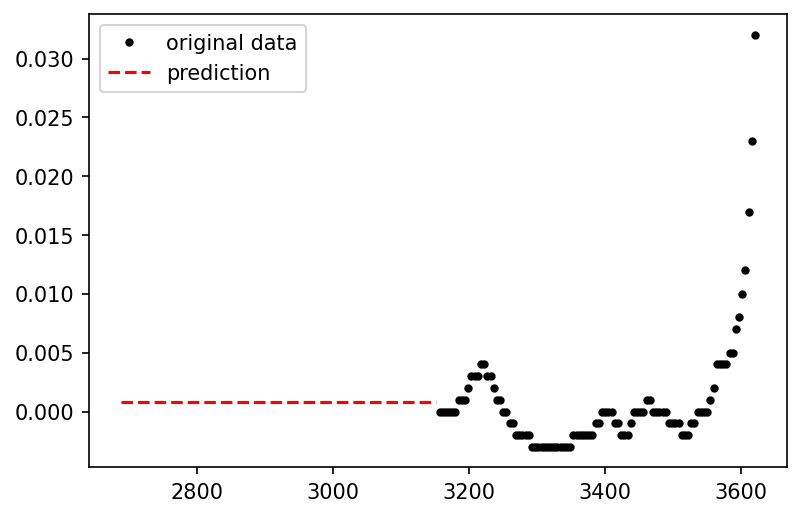

In [6]:
x_data = x_all[575:675]
y_data = y_all[575:675]

rbf_data = rbf(x_data)
model = LinearRegression()
model.fit(rbf_data, y_data)

rbf_test = rbf(x_data, x_third)
yhat = model.predict(rbf_test)

r2 = model.score(rbf_test, y_third)
print('r^2: {}'.format(r2))

fig, ax = plt.subplots(dpi = 150)
ax.plot(x_data, y_data, '.k', label = 'original data')
ax.plot(x_third, yhat, '--r', label = 'prediction')
ax.legend()
plt.show()

**What does negative $r^2$ mean?**

The model is really bad.

## 2. Cauchy Kernel Matrix

**Write a function that computes the Cauchy kernel between any two vectors $x_i$ and $x_j$.**

Consider the Cauchy distribution defined by:

$C(x, x_0, \gamma) = \frac{1}{\pi\gamma} \left( \frac{\gamma^2}{(x-x_0)^2 + \gamma^2} \right)$

- $x_0$ is the center of the distribution. Comparable to the mean ($\mu$) of a Gaussian distribution.
- $\gamma$ is a scale factor. Comparable to the standard deviation ($\sigma$) of a Gaussian distribution.

In [7]:
def cauchy_kernel(x, x_0, gamma):
    N = len(x)
    M = len(x_0)
    
    cauchy_matrix = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            cauchy_matrix[i, j] = gamma**2 / (gamma**2 + (x[i] - x_0[j])**2) / np.pi / gamma
       
    return cauchy_matrix

**Visualize kernel matrices for the ethanol spectra dataset.**

Vary the $\gamma$ with [1, 10, 100].

You may want to use the `plt.imshow` function to visualize the matrices.
Here is an example of using `plt.imshow`.

For more details, see the documentation: https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.pyplot.imshow.html.

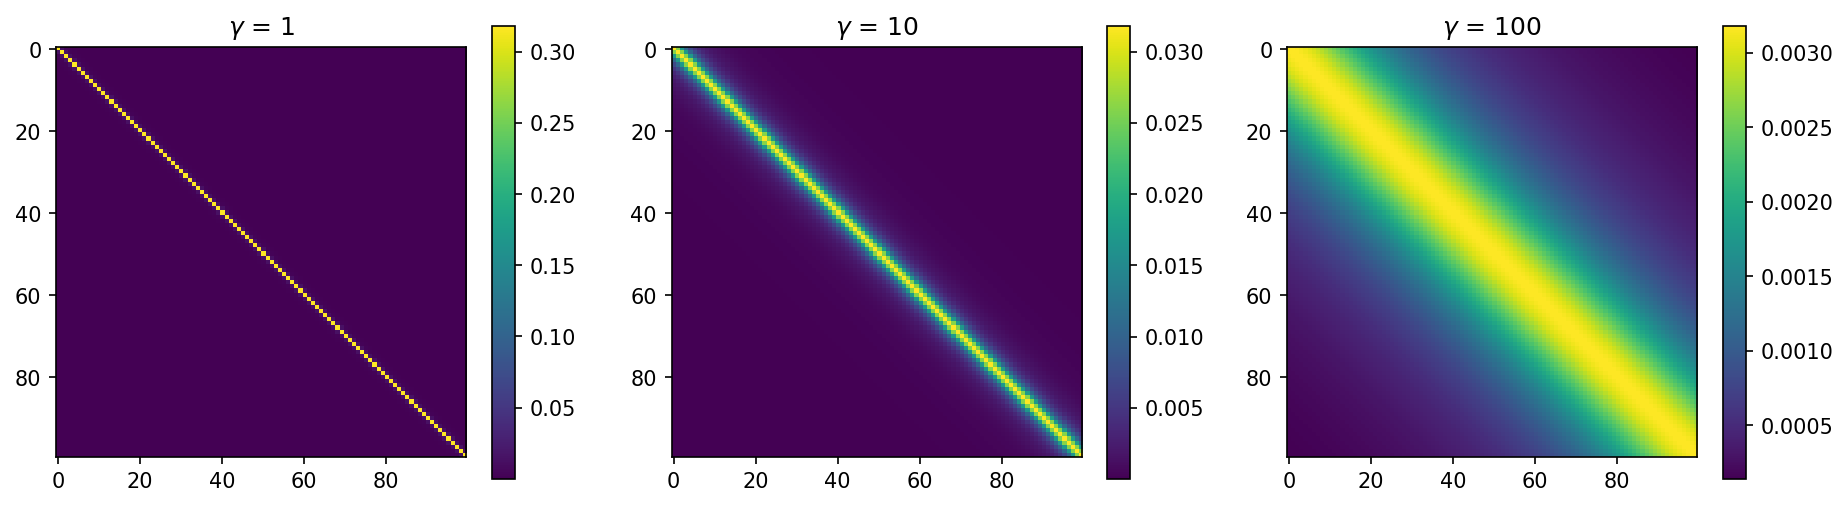

In [8]:
gammas = np.array([1, 10, 100])

fig, axes = plt.subplots(1, 3, figsize = (15, 4), dpi = 150)

for i, gamma in enumerate(gammas):
    cauchy = cauchy_kernel(x_peak, x_peak, gamma)
    im = axes[i].imshow(cauchy, cmap = 'viridis')
    axes[i].set_title('$\gamma$ = {}'.format(gamma))
    
    fig.colorbar(im, ax = axes[i])
    
plt.show()

**Briefly discuss the structure of these matrices.**

As $\gamma$ increases, the distribution becomes wider.

## 3. Anscomb's Quartet

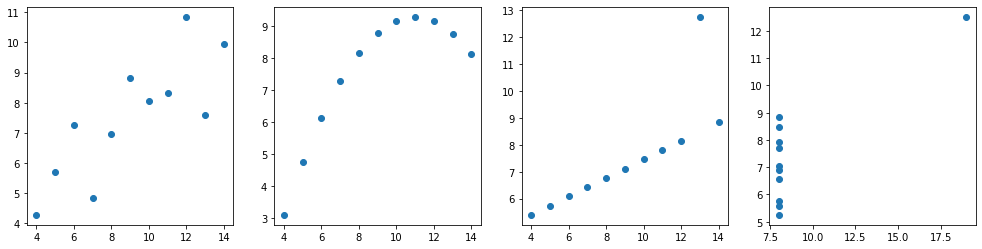

In [9]:
x_aq = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
y1_aq = np.array([8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68])
y2_aq = np.array([9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74])
y3_aq = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73])
x4_aq = np.array([8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8])
y4_aq = np.array([6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89])

fig, axes = plt.subplots(1, 4, figsize = (17, 4))

axes[0].scatter(x_aq, y1_aq)
axes[1].scatter(x_aq, y2_aq)
axes[2].scatter(x_aq, y3_aq)
axes[3].scatter(x4_aq, y4_aq);

**Compute the means and standard deviations of each dataset.**

In [10]:
print('Dataset 1 - mean: {}\tstd: {}'.format(y1_aq.mean(), y1_aq.std()))
print('Dataset 2 - mean: {}\tstd: {}'.format(y2_aq.mean(), y2_aq.std()))
print('Dataset 3 - mean: {}\tstd: {}'.format(y3_aq.mean(), y3_aq.std()))
print('Dataset 4 - mean: {}\tstd: {}'.format(y4_aq.mean(), y4_aq.std()))

Dataset 1 - mean: 7.500909090909093	std: 1.937024215108669
Dataset 2 - mean: 7.50090909090909	std: 1.93710869148962
Dataset 3 - mean: 7.5	std: 1.9359329439927313
Dataset 4 - mean: 7.500909090909091	std: 1.9360806451340837


**Use a linear regression to find a model $\hat{y}=mx+b$ for each dataset.**

Create a parity plot between the model and the actual $y$ values.

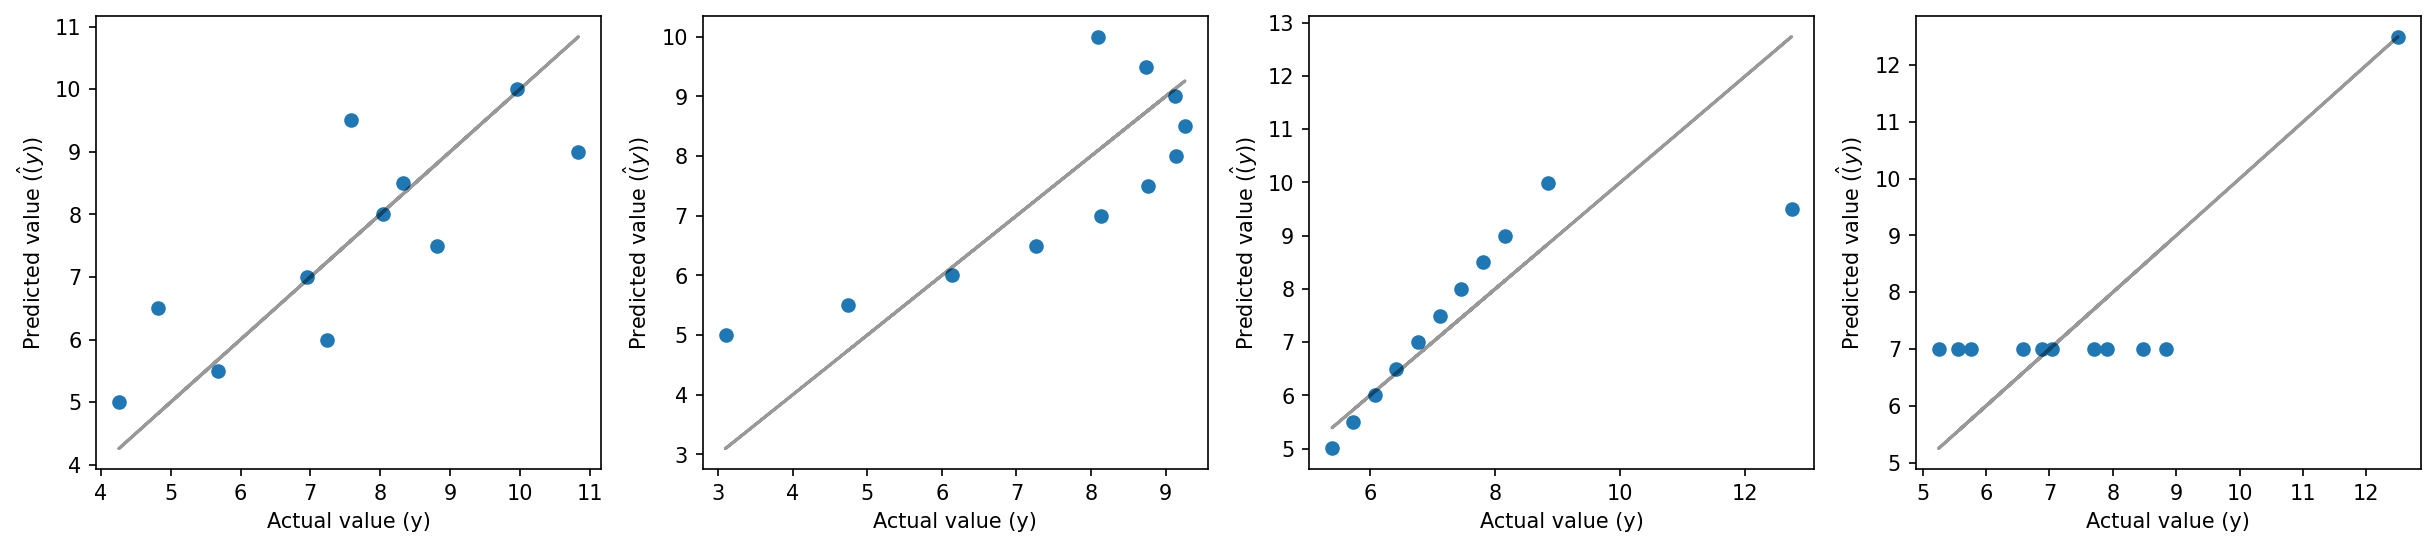

In [11]:
def calc_stats(x, y):
    m, b = np.polyfit(x, y, deg = 1)
    return m, b

xList = [x_aq, x_aq, x_aq, x4_aq]
yList = [y1_aq, y2_aq, y3_aq, y4_aq]
yhatList = []

for i, x in enumerate(xList):
    m, b = calc_stats(x, yList[i])
    yhatList.append(m * x + b)
    
fig, axes = plt.subplots(1, 4, figsize = (20, 4), dpi = 150)
for i, ax in enumerate(axes):
    ax.scatter(yList[i], yhatList[i])
    ax.plot(yList[i], yList[i], '-k', alpha = .4)
    ax.set_xlabel('Actual value (y)')
    ax.set_ylabel('Predicted value ($\hat(y)$)')
    
plt.show()

## 4. Assumptions for Linear Regression

**List the assumptions of linear regression and the corresponding error estimation based on the standard deviation of the error.**

Linear regression assumptions:
- Error is normally distributed
- Error is homoscedastic
- The relationship between the variable is linear

We can calculate the uncertainty of the error based on the standard deviation of the error by using the following equation:

$\vec\sigma_y = \sigma_{error} \sqrt{1 + \frac{1}{n} + \frac{(\vec{x} - \bar{x})^2}{(\sum_j x_j - \bar{x})^2}}$

where $\vec\sigma_y$ is the uncertainty and $\sigma_{error}$ is the standard deviation of the error.